<a href="https://colab.research.google.com/github/mitsu-h/BirdCLEF/blob/make_train_note/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
from datetime import datetime

import torchaudio
from torchaudio import transforms
import torchvision

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [3]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


torch_fix_seed()

# Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')
root_dir="/content/drive/MyDrive/colab/BirdCLEF/"
data_dir= os.path.join(root_dir, "inputs/")
model_dir = os.path.join(root_dir, "models/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_df = pd.read_csv(os.path.join(data_dir, 'train_metadata.csv'))
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


# Quick EDA and Data Pre-processing

In [6]:
train_df.shape

(14852, 13)

In [7]:
train_df.describe()

,latitude,longitude,rating
count,14852.000000,14852.000000,14852.000000
mean,35.778958,-30.217719,3.719129
std,22.288169,73.679144,1.181014
min,-71.883400,-176.632200,0.000000
25%,28.259200,-96.164300,3.000000
50%,40.870800,-6.061100,4.000000
75%,51.121950,10.897800,4.500000
max,78.978300,179.360700,5.000000


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14852 entries, 0 to 14851
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     14852 non-null  object 
 1   secondary_labels  14852 non-null  object 
 2   type              14852 non-null  object 
 3   latitude          14852 non-null  float64
 4   longitude         14852 non-null  float64
 5   scientific_name   14852 non-null  object 
 6   common_name       14852 non-null  object 
 7   author            14852 non-null  object 
 8   license           14852 non-null  object 
 9   rating            14852 non-null  float64
 10  time              14852 non-null  object 
 11  url               14852 non-null  object 
 12  filename          14852 non-null  object 
dtypes: float64(3), object(10)
memory usage: 1.5+ MB


Looks like no null values are there.

In [9]:
# For this baseline notebook, we would consider following columns 
columns_of_interest = ['primary_label', 'rating', 'filename']
train_df = train_df[columns_of_interest]
train_df.head()

,primary_label,rating,filename
0,afrsil1,2.5,afrsil1/XC125458.ogg
1,afrsil1,3.5,afrsil1/XC175522.ogg
2,afrsil1,4.0,afrsil1/XC177993.ogg
3,afrsil1,4.0,afrsil1/XC205893.ogg
4,afrsil1,3.0,afrsil1/XC207431.ogg


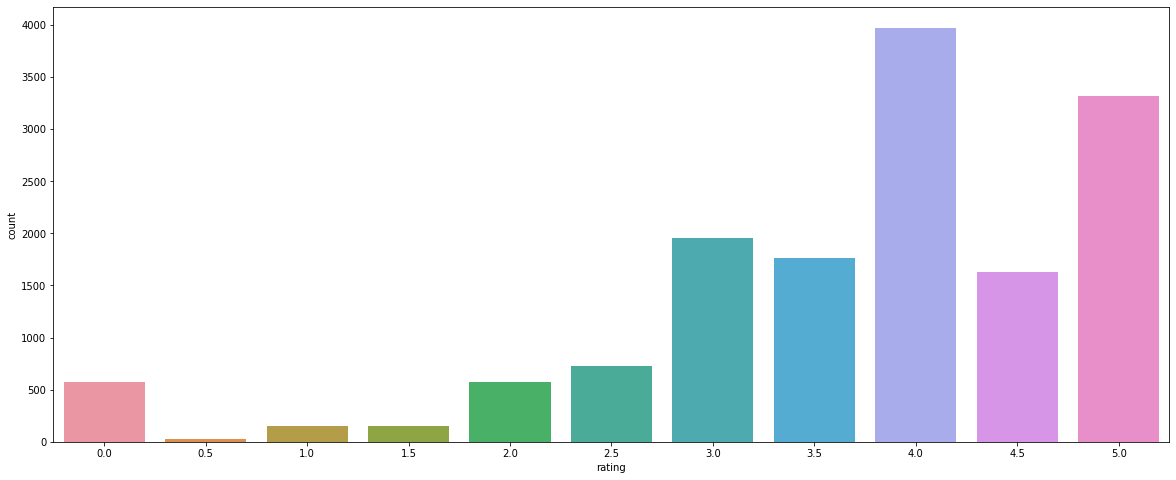

In [10]:
f, ax = plt.subplots(figsize=(20,8))
sns.countplot(x='rating', data=train_df, ax=ax)

we will consider only those audio files whose rating >= 3.0

In [11]:
train_df = train_df[train_df.rating >= 3.0]

In [12]:
train_df = train_df.reset_index(drop=True)
train_df.head()

,primary_label,rating,filename
0,afrsil1,3.5,afrsil1/XC175522.ogg
1,afrsil1,4.0,afrsil1/XC177993.ogg
2,afrsil1,4.0,afrsil1/XC205893.ogg
3,afrsil1,3.0,afrsil1/XC207431.ogg
4,afrsil1,4.0,afrsil1/XC207432.ogg


In [13]:
labels = train_df.primary_label.unique().tolist()

In [14]:
label2id = {labels[i]: i for i in range(len(labels))}

In [15]:
labels[0], label2id['afrsil1']

('afrsil1', 0)

In [16]:
train_audio_dir = os.path.join(data_dir, 'train_audio')

In [17]:
# for i in tqdm(range(len(train_df))):
#     filename = train_df.loc[i,'filename']
#     sig, sr = torchaudio.load(os.path.join(train_audio_dir, filename))
#     train_df.loc[i, 'num_channels'] = sig.shape[0]  # number of audio channels (mono/stereo)
#     train_df.loc[i, 'signal_len'] = sig.shape[1]  # signal length
#     train_df.loc[i, 'sampling_rate'] = sr

In [18]:
# train_df['num_channels'] = train_df['num_channels'].astype('int64')
# train_df['signal_len'] = train_df['signal_len'].astype('int64')
# train_df['sampling_rate'] = train_df['sampling_rate'].astype('int64')
# train_df.head()

In [19]:
# train_df.sampling_rate.unique()

we have unqiue sampling rate i.e., 32 KHz

For a 1 second video, the array size will be 32000

In [20]:
# sns.countplot(train_df.num_channels)

There are more number of two channel audios. So we will convert mono (1 channel ) audio to stereo (2 channel) audio by replication.

In [21]:
def MonoToStereo(aud, num_channel=2):
    sig, sr = aud
    if sig.shape[0] == num_channel:
        return aud
    else:
        stereo_sig = torch.cat([sig, sig])
    
    return (stereo_sig, sr)

In [22]:
# train_df.signal_len.min(), train_df.signal_len.max()

In [23]:
# f, ax = plt.subplots(figsize=(15,8))
# sns.distplot(train_df.signal_len, ax=ax)

we need to have signal length to be of same size. So we will either pad the signal or truncate the signal.

In [24]:
# Let's consider the length of all videos to be 10 seconds (A hyperparam - to be tuned)
max_len_ms = 10000 # 10k milliseconds ~ 10 seconds

def pad_signal(aud, max_len_ms):
    sig, sr = aud
    num_channels, sig_len = sig.shape
    max_len = sr // 1000 * max_len_ms
    
    if sig_len > max_len:
        sig = sig[:, :max_len]
    elif sig_len < max_len:
        # padding both sides of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len
        
        # pad with zeros
        pad_begin = torch.zeros((num_channels, pad_begin_len))
        pad_end = torch.zeros((num_channels, pad_end_len))
        
        sig = torch.cat((pad_begin, sig, pad_end), 1)
    
    return (sig, sr)

In [25]:
# Data Augmentation on raw audio: Time shift
def time_shift(aud, shift_limit):
    sig, sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

In [26]:
# Convert augmented audio to Mel Spectrogram
def mel_spec(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig, sr = aud
    top_db = 80
    
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)
    # shape of spec: (channels, n_mels, time)
    
    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    
    # Add channel
    spec = torch.cat([spec, spec.mean(dim=0, keepdim=True)])
    return spec

In [27]:
# Data augmentation on mel spectrogram: Time and Frequency Masking
def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec
    
    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)
        
    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)
        
    return aug_spec

Preprocessing on one signal sample

In [28]:
idx = random.randint(0, len(train_df))
filename = train_df.loc[idx,'filename']
sig, sr = torchaudio.load(os.path.join(train_audio_dir, filename))
audio_sample = (sig, sr)

# mono to stereo (if mono)
audio = MonoToStereo(audio_sample)

# Pad or Truncate
audio = pad_signal(audio, max_len_ms)

# Augment on raw audio
audio = time_shift(audio, shift_limit=0.4)

# Convert to Mel Spectrogram
spec = mel_spec(audio)

# resize Mel Spec
spec = torchvision.transforms.Resize((224, 224))(spec)

# Augment on mel spec
aug_spec = spectro_augment(spec)
aug_spec.shape

torch.Size([3, 224, 224])

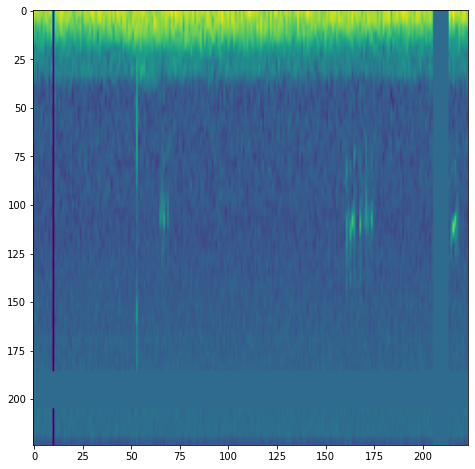

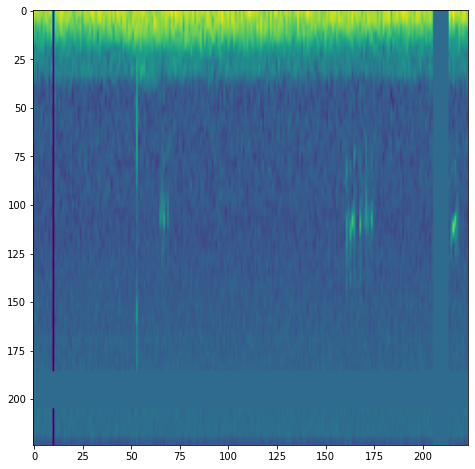

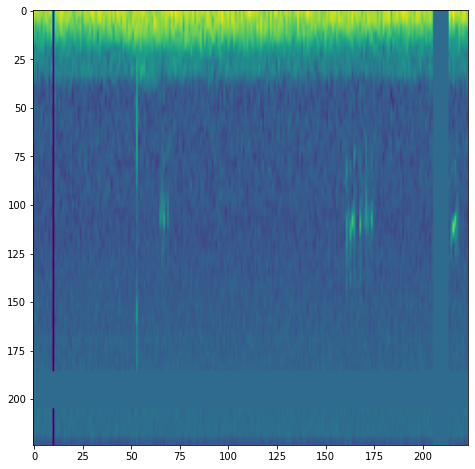

In [29]:
aug_spec_np = aug_spec.permute(1,2,0).numpy()
f, ax = plt.subplots(figsize=(15,8))
plt.imshow(aug_spec_np[:, :, 0])
plt.show()
f, ax = plt.subplots(figsize=(15,8))
plt.imshow(aug_spec_np[:, :, 1])
plt.show()
f, ax = plt.subplots(figsize=(15,8))
plt.imshow(aug_spec_np[:, :, 1])
plt.show()

# Building Custom Dataset

In [30]:
class CustomDataset(Dataset):
    def __init__(self, audio_dir, df, max_len_ms=10000, shift_limit=0.4, input_size=224):
        self.train_audio_dir = audio_dir
        self.train_df = df
        self.max_len_ms = max_len_ms
        self.shift_limit = shift_limit
        self.input_size = input_size
        
    def __len__(self):
        return len(self.train_df)

    def __getitem__(self, index):
        filename = self.train_df.loc[index, 'filename']
        label = self.train_df.loc[index, 'primary_label']
        
        sig, sr = torchaudio.load(os.path.join(self.train_audio_dir, filename))
        audio = (sig, sr)
        
        ##################        
        # process signal #
        ##################
        
        # mono to stereo (if mono)
        audio = MonoToStereo(audio)

        # Pad or Truncate
        audio = pad_signal(audio, self.max_len_ms)

        # Augment raw audio
        audio = time_shift(audio, shift_limit=self.shift_limit)

        # Convert to Mel Spectrogram
        spec = mel_spec(audio)
        
        # resize Mel Spec
        spec = torchvision.transforms.Resize((self.input_size, self.input_size))(spec)

        # Augment mel spec
        aug_spec = spectro_augment(spec)
        
        return aug_spec, torch.tensor(label2id[label])

In [31]:
max_len_ms = 10000
shift_limit = 0.4
input_size = 224
dataset = CustomDataset(train_audio_dir, train_df, max_len_ms, shift_limit, input_size)

In [32]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [33]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
inputs, targets = next(iter(train_loader))
inputs.shape, targets.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Cool!!

Let's build model architecture.

# Model Building

### model作成の関数
基本的に、モデルを変更する場合はここの修正を行う！

In [35]:
def create_model(labels, device):
  model = torchvision.models.resnet50(num_classes=len(labels))
  model.fc = torch.nn.Sequential(
    torch.nn.Linear(
        in_features=model.fc.in_features,
        out_features=model.fc.out_features
    ),
    torch.nn.Sigmoid()
  )
  return model.to(device)

### modelのチェック

In [36]:
model = create_model(labels, 'cpu')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
model.eval()
output = model(inputs)
output.shape

torch.Size([32, 151])

In [38]:
LERANING_RATE = 1e-4

# Defining loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LERANING_RATE)

# Model Training

In [39]:
def train_epoch(model, data_loader, device, criterion, optimizer):
    model.train()

    losses = []
    correct = 0
    total = 0

    for batch_idx, (x, y) in enumerate(tqdm(data_loader)):
        x = x.to(device) 
        y = y.to(device) 

        output = model(x)

        loss = criterion(output, y)

        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(output, dim=1)
        correct += (preds.cpu() == y.cpu()).sum().item()
        total += preds.size(0)

    acc = (correct * 1.0) / total

    return acc, np.mean(losses)

In [40]:
def val_epoch(model, data_loader, device, criterion):
    model.eval()

    losses = []
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(tqdm(data_loader)):
            x = x.to(device) 
            y = y.to(device) 

            output = model(x)

            loss = criterion(output, y)

            losses.append(loss.item())

            _, preds = torch.max(output, dim=1)
            correct += (preds.cpu() == y.cpu()).sum().item()
            total += preds.size(0)

    acc = (correct * 1.0) / total

    return acc, np.mean(losses)

In [41]:
def train(model, epochs, device, train_loader, val_loader, criterion, optimizer, model_name):
    history = defaultdict(list)

    best_val_acc = 0

    for epoch in range(epochs):
        print(f'Epoch: {epoch + 1}/{epochs}')
        print('-' * 10)
        print('Training')
        train_acc, train_loss = train_epoch(model, train_loader, device, criterion, optimizer)
        print('\nValidating')
        val_acc, val_loss = val_epoch(model, val_loader, device, criterion)

        print(f'\nTrain Loss: {train_loss}\tTrain Acc: {train_acc}')
        print(f'Val Loss: {val_loss}\tVal Acc: {val_acc}')

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_name)

    return history

In [42]:
EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [43]:
# modelの上書きを防ぐため、指定した名前or日付をつける
suffix = None # 日付以外の名前を付けたい場合はここを適当な文字列に変更
suffix = suffix or datetime.now().strftime("%Y%m%d%H%M")
model_name = os.path.join(model_dir, f"best_model_{suffix}.pth.tar")

In [ ]:
model = model.to(DEVICE)
history = train(model, EPOCHS, DEVICE, train_loader, val_loader, criterion, optimizer, model_name)

Epoch: 1/10
----------
Training


100%|██████████| 317/317 [1:05:38<00:00, 12.42s/it]



Validating


100%|██████████| 80/80 [15:34<00:00, 11.68s/it]



Train Loss: 4.665330452121771	Train Acc: 0.03795966785290629
Val Loss: 4.629882740974426	Val Acc: 0.0391304347826087
Epoch: 2/10
----------
Training


100%|██████████| 317/317 [26:25<00:00,  5.00s/it]



Validating


100%|██████████| 80/80 [05:52<00:00,  4.40s/it]



Train Loss: 4.611429679280952	Train Acc: 0.049031237643337285
Val Loss: 4.585996866226196	Val Acc: 0.043478260869565216
Epoch: 3/10
----------
Training


 26%|██▌       | 83/317 [07:03<21:28,  5.50s/it]

# Model Testing

In [ ]:
model.load_state_dict(torch.load(model_name))